Удалила "2 Зрелый почерк-(обычный почерк)-2.jpg" (там печатный текст)

# Config

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/Colab\ Notebooks/mest

/content/drive/MyDrive/Colab Notebooks/mest


In [33]:
DATA = "bin"
DATA_POS = f"{DATA}/1"
DATA_NEG = f"{DATA}/0"

import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
THRESHOLD = 0.999 # доля белого
SEED = 42
BATCH_SIZE = 8
LR = 1e-4
EPOCHES = 34
EPOCHES_CL = 20
POS_AUG = 22
NEG_AUG = 2
PATH = "m.pth"
PATH_CL = "c.pth"

LOG_PATH = "log.txt"

glob_dict = {
    "DEVICE": DEVICE,
    "THRESHOLD": THRESHOLD,
    "SEED": SEED,
    "BATCH_SIZE": BATCH_SIZE,
    }

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from time import time

from src.functions import *
from src.dataset import *
from src.train import *

print(f"{DEVICE = }")

DEVICE = device(type='cuda')


In [4]:
"seed_everything(42)"

'seed_everything(42)'

# Dataset

In [6]:
transform = transforms.Compose([
    transforms.RandomCrop(300),
    # transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

pos_dataset = My_Dataset(
    "pos", DATA_POS, augmentation=POS_AUG, transform=transform, globals=glob_dict)
print(f"Positive: {len(pos_dataset)}    ({pos_dataset.real_len})")

neg_dataset = My_Dataset(
    "neg", DATA_NEG, augmentation=NEG_AUG, transform=transform, globals=glob_dict)
print(f"Negative: {len(neg_dataset)}    ({neg_dataset.real_len})")

Positive: 484    (22)
Negative: 448    (224)


# freeze_layers

In [7]:
def number_of_parameters(model):
    return f"{sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters"

In [8]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# list(model.children())
# dir(model)
print(f"num parameters = {number_of_parameters(model)}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]

num parameters = 11689512 parameters


In [9]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [10]:
num_layers = len(list(model.children()))
print(f"Число слоёв: {num_layers}")
num_classes = 1000
print(f"Число классов: {num_classes}")
num_freeze_layers = num_layers - 2

seed_everything(42)
model = create_model(model, num_freeze_layers, num_classes).to(DEVICE)

Число слоёв: 10
Число классов: 1000


In [11]:
print(f"num parameters = {number_of_parameters(model)}")

num parameters = 513000 parameters


In [12]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [13]:
# for i, layer in enumerate(model.children()):
#     for param in layer.parameters():
#         if param.requires_grad:
#             print(i, layer, param.shape, param.requires_grad, sep = "\n")

In [14]:
# model.load_state_dict(torch.load(PATH, map_location=DEVICE))

# Code

In [15]:
# https://habr.com/ru/articles/794750/

class TripletDataset(Dataset):
    def __init__(self, dataset1, dataset2, required_len, deterministic=True, seed=42):
        self.d1 = dataset1
        self.d2 = dataset2
        self.len1 = len(dataset1)
        self.len2 = len(dataset2)
        self.required_len = required_len
        self.deterministic = deterministic

        if self.deterministic:
            seed_everything(seed)
            self.X = []

            for i in range(self.required_len):
                anchor, positive = random.sample(range(self.len1), 2)
                negative = random.randrange(self.len2)

                ds = [self.d1, self.d1, self.d2]
                idxs = [anchor, positive, negative]
                self.X.append(tuple(dataset[i][0] for dataset, i in zip(ds, idxs)))

    def __len__(self):
        return self.required_len

    def __getitem__(self, idx):
        if idx < len(self):

            if self.deterministic:
                return self.X[idx]
            else:
                anchor, positive = random.sample(range(self.len1), 2)
                negative = random.randrange(self.len2)

                ds = [self.d1, self.d1, self.d2]
                idxs = [anchor, positive, negative]
                return tuple(dataset[i][0] for dataset, i in zip(ds, idxs))
        else:
            raise IndexError

In [16]:
# d = TripletDataset([0, 1, 2, 3, 4, 5], [10, 11, 12, 13, 14, 15], 10)

In [17]:
# for i in d:
#     print(i)

In [18]:
def train_epoch(model, dataloader, loss_fn, optimizer, device):

    model.train()
    running_loss = 0.0

    for data in dataloader:
        anchor, positive, negative = [d.to(device) for d in data]

        optimizer.zero_grad()

        anchor_output = model(anchor)
        positive_output = model(positive)
        negative_output = model(negative)

        loss = loss_fn(anchor_output, positive_output, negative_output)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)

In [19]:
def validate_epoch(model, dataloader, loss_fn, device):

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            anchor, positive, negative = [d.to(device) for d in data]
            anchor_output = model(anchor)
            positive_output = model(positive)
            negative_output = model(negative)

            loss = loss_fn(anchor_output, positive_output, negative_output)
            running_loss += loss.item()

            total += anchor.size(0)
            correct += (torch.norm(anchor_output - positive_output, dim=1) <
                        torch.norm(anchor_output - negative_output, dim=1)).sum().item()

    accuracy = 100 * correct / total
    return running_loss / len(dataloader), accuracy

# train

In [20]:
dataset = TripletDataset(pos_dataset, neg_dataset, 1000)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

triplet_loss = nn.TripletMarginLoss(margin=9.0, p=2)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.to(DEVICE)

for epoch in range(EPOCHES):
    train_loss = train_epoch(model, train_loader, triplet_loss, optimizer, DEVICE)
    val_loss, val_accuracy = validate_epoch(model, val_loader, triplet_loss, DEVICE)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:6.5f}, Val Loss: {val_loss:6.5f}, Val Accuracy: {val_accuracy:6.5f}%")

torch.save(model.state_dict(), PATH)

Epoch 1, Train Loss: 7.52845, Val Loss: 5.22182, Val Accuracy: 78.50000%
Epoch 2, Train Loss: 4.22808, Val Loss: 3.85311, Val Accuracy: 86.00000%
Epoch 3, Train Loss: 2.67443, Val Loss: 3.04544, Val Accuracy: 88.50000%
Epoch 4, Train Loss: 2.01787, Val Loss: 2.81862, Val Accuracy: 91.50000%
Epoch 5, Train Loss: 1.73054, Val Loss: 2.92920, Val Accuracy: 88.00000%
Epoch 6, Train Loss: 1.23990, Val Loss: 2.06128, Val Accuracy: 92.00000%
Epoch 7, Train Loss: 1.08032, Val Loss: 2.05094, Val Accuracy: 93.00000%
Epoch 8, Train Loss: 0.94526, Val Loss: 2.27686, Val Accuracy: 91.00000%
Epoch 9, Train Loss: 0.75958, Val Loss: 1.96953, Val Accuracy: 93.00000%
Epoch 10, Train Loss: 0.70465, Val Loss: 1.99752, Val Accuracy: 92.50000%
Epoch 11, Train Loss: 0.65348, Val Loss: 2.17324, Val Accuracy: 90.00000%
Epoch 12, Train Loss: 0.54489, Val Loss: 1.87960, Val Accuracy: 92.50000%
Epoch 13, Train Loss: 0.49059, Val Loss: 1.82380, Val Accuracy: 93.50000%
Epoch 14, Train Loss: 0.63563, Val Loss: 1.9509

In [21]:
val_loss, val_accuracy = validate_epoch(model, val_loader, triplet_loss, DEVICE)
val_loss, val_accuracy

(1.463847885131836, 94.0)

# train 2

In [22]:
class Emb_Dataset(Dataset):
    def __init__(self, model, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if idx < len(self):
            img, cls = self.dataset[idx]
            emb = model(img[None, :].to(DEVICE))[0]
            return emb, cls
        else:
            raise IndexError

In [23]:
# model.load_state_dict(torch.load(PATH, map_location=DEVICE))

In [24]:
model(pos_dataset[0][0][None, :].to(DEVICE)).shape

torch.Size([1, 1000])

In [38]:
# model(pos_dataset[0][0][None, :])

In [25]:
dataset = torch.utils.data.ConcatDataset([pos_dataset, neg_dataset]) # подряд идут 1, потом 0
print(f"ConcatDataset: {len(dataset)}")

emb_dataset = Emb_Dataset(model, dataset)

seed_everything(42)
train_dataset, test_dataset = split_dataset(emb_dataset)

ConcatDataset: 932
Train: 745
 Test: 187
 Total: 932


In [26]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}\n Test batches: {len(test_loader)}")

Train batches: 94
 Test batches: 24


In [27]:
pos_neg(train_loader)

{'1': 381, '0': 364, 'total': 745}

In [28]:
pos_neg(test_loader)

{'1': 103, '0': 84, 'total': 187}

In [29]:
X_batch, y_batch = next(iter(train_loader))

X_batch.shape, y_batch.shape

(torch.Size([8, 1000]), torch.Size([8]))

In [30]:
NN = nn.Sequential(nn.Linear(1000, 512),
                   nn.ReLU(),
                   nn.Linear(512, 2)).to(DEVICE)

In [31]:
print(f"num parameters = {number_of_parameters(NN)}")

num parameters = 513538 parameters


In [35]:
start_time = time()

seed_everything(42)

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(NN.parameters(), lr=learning_rate)

NN = train(NN, train_loader, test_loader, loss_fn, optimizer, n_epoch=EPOCHES_CL, globals=glob_dict)
torch.save(NN.state_dict(), PATH_CL)

print(f"# Время работы: {(time() - start_time):6.5f}s")

# Epoch 1/20 train/val: loss 0.32836/0.38972, accuracy: 0.87785/0.83422
# Epoch 2/20 train/val: loss 0.25249/0.31904, accuracy: 0.93154/0.87166
# Epoch 3/20 train/val: loss 0.26040/0.34603, accuracy: 0.89664/0.82888
# Epoch 4/20 train/val: loss 0.16808/0.27243, accuracy: 0.96107/0.88770
# Epoch 5/20 train/val: loss 0.14791/0.27913, accuracy: 0.95973/0.89840
# Epoch 6/20 train/val: loss 0.12042/0.26262, accuracy: 0.97450/0.90374
# Epoch 7/20 train/val: loss 0.10495/0.26791, accuracy: 0.98658/0.89840
# Epoch 8/20 train/val: loss 0.10168/0.30989, accuracy: 0.97718/0.88770
# Epoch 9/20 train/val: loss 0.09318/0.32028, accuracy: 0.96913/0.88235
# Epoch 10/20 train/val: loss 0.06479/0.28027, accuracy: 0.99597/0.90374
# Epoch 11/20 train/val: loss 0.05877/0.29297, accuracy: 0.99060/0.90909
# Epoch 12/20 train/val: loss 0.04707/0.29755, accuracy: 0.99463/0.90909
# Epoch 13/20 train/val: loss 0.04253/0.29589, accuracy: 0.99732/0.89840
# Epoch 14/20 train/val: loss 0.03499/0.31130, accuracy: 1.0

# eval

In [134]:
class Pipeline(nn.Module):
    def __init__(self, model, NN):
        super().__init__()
        self.model = model
        self.NN = NN

    def forward(self, x):
        x = self.model(x.to(DEVICE))
        x = self.NN(x)
        return x

In [135]:
pipe = Pipeline(model, NN)

In [136]:
y_pred, y_true, y_prob, _ = get_predictions(pipe, pos_dataset, globals=glob_dict)
print(accuracy_score(y_pred, y_true))

0.9896694214876033


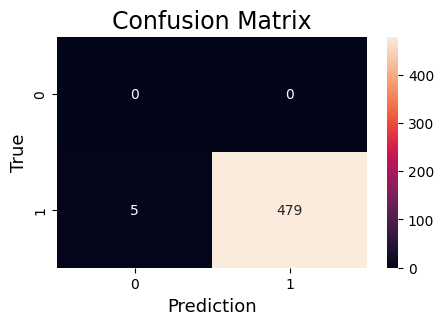

array([[  0,   0],
       [  5, 479]])

In [137]:
confusion_matrix(y_true, y_pred)

In [138]:
y_pred, y_true, y_prob, _ = get_predictions(pipe, neg_dataset, globals=glob_dict)
print(accuracy_score(y_pred, y_true))

0.9754464285714286


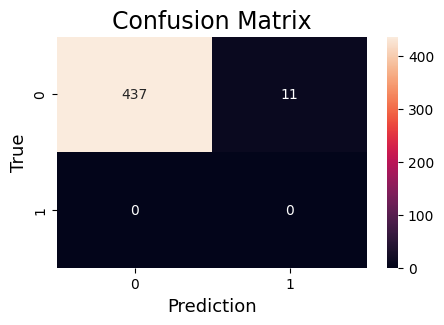

array([[437,  11],
       [  0,   0]])

In [139]:
confusion_matrix(y_true, y_pred)

# show

0.9896694214876033


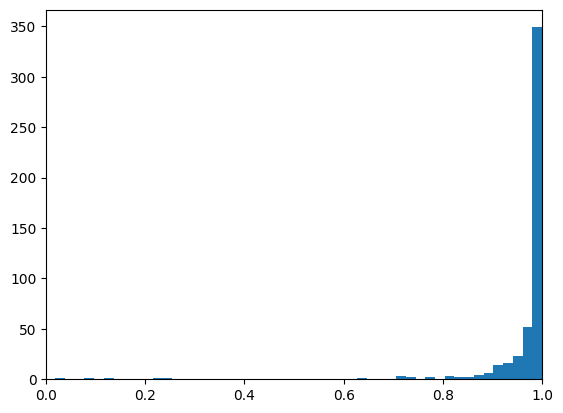

In [140]:
y_pred, y_true, y_prob, _ = get_predictions(pipe, pos_dataset, globals=glob_dict)
print(accuracy_score(y_pred, y_true))

_ = plt.hist(y_prob.numpy(), bins = 50)
plt.xlim((0,1))
plt.show()
# 0.9896694214876033

0.9754464285714286


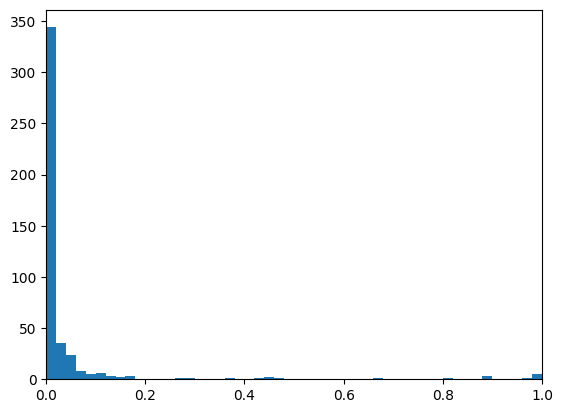

In [142]:
y_pred, y_true, y_prob, _ = get_predictions(pipe, neg_dataset, globals=glob_dict)
print(accuracy_score(y_pred, y_true))

_ = plt.hist(y_prob.numpy(), bins = 50)
plt.xlim((0,1))
plt.show()
# 0.9754464285714286

prob > 0.8
count : 471 out of 484
pic idx : [0, 1, 2, 3, 4, 5, 6, 7]


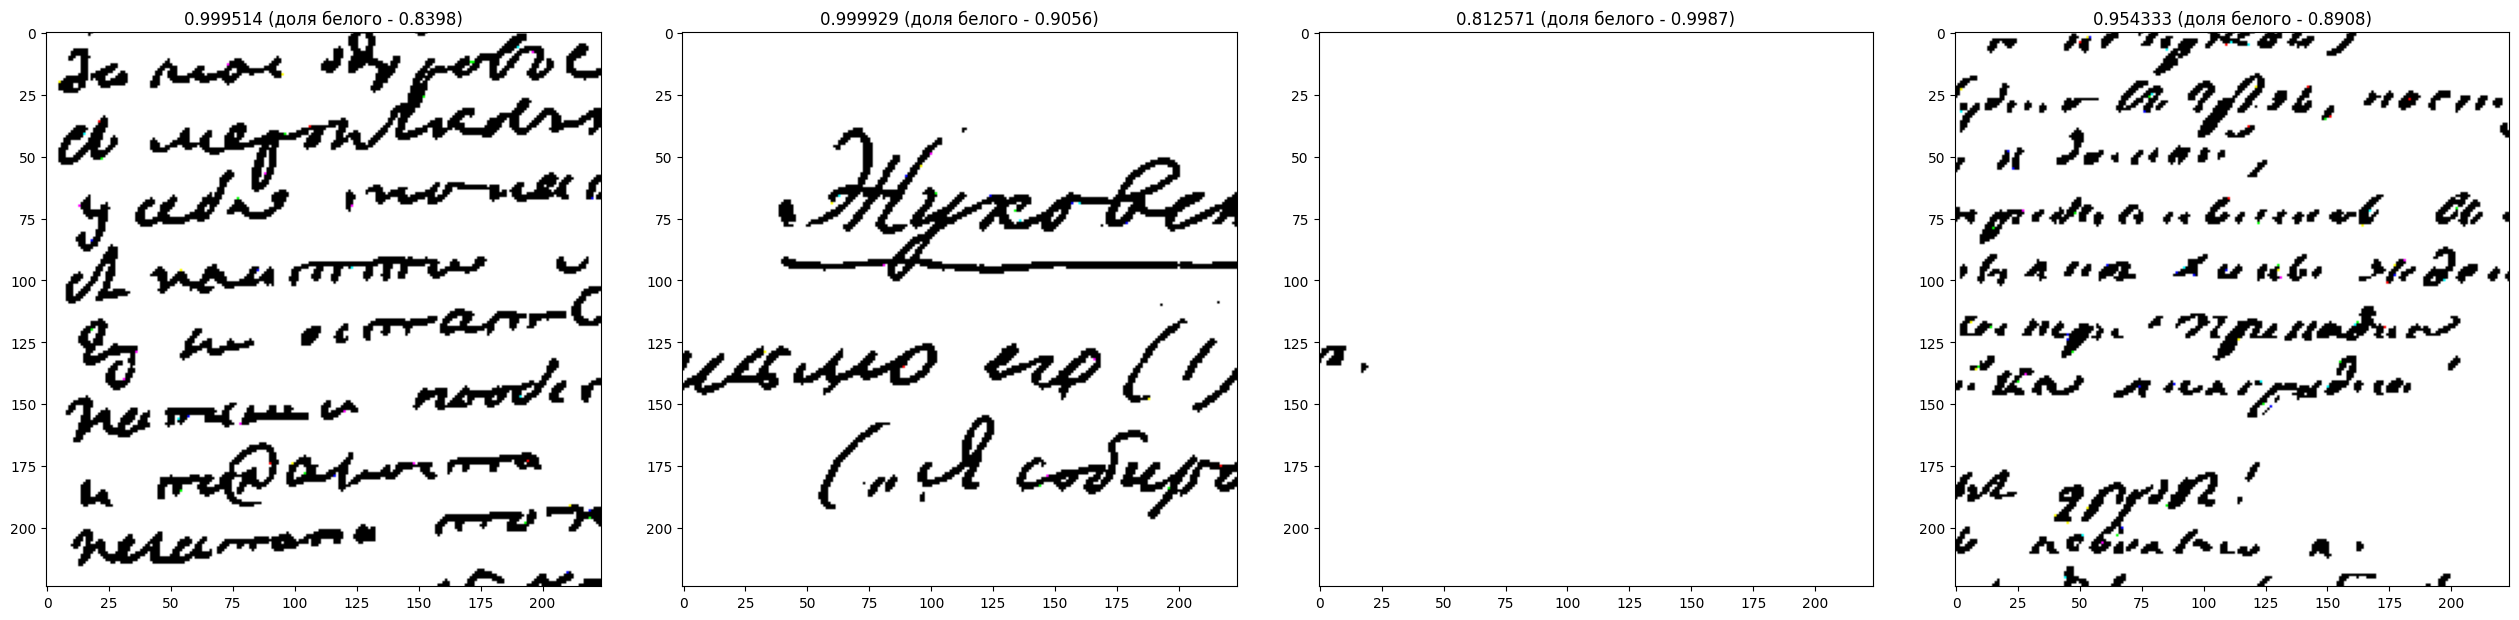

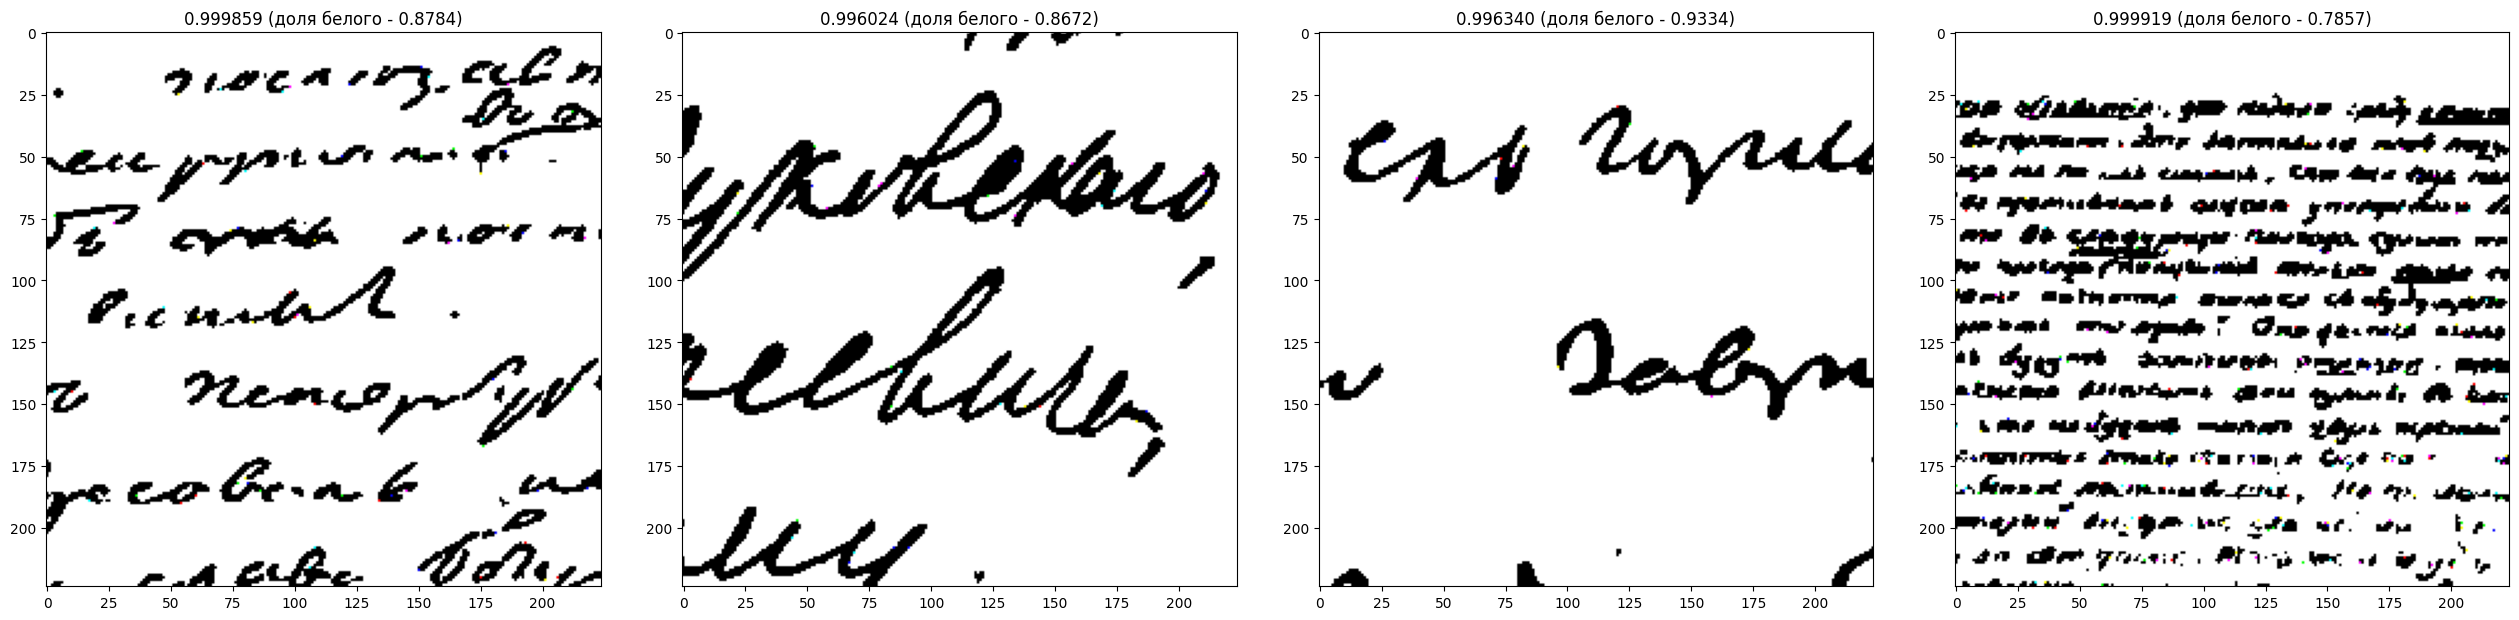

In [143]:
y_pred, _, y_prob, X = show_result(pipe, pos_dataset, 0.8, greater=True, col = 8,
                                   globals=glob_dict)

prob < 0.6
count : 5 out of 484
pic idx : [223, 349, 400, 407, 451]


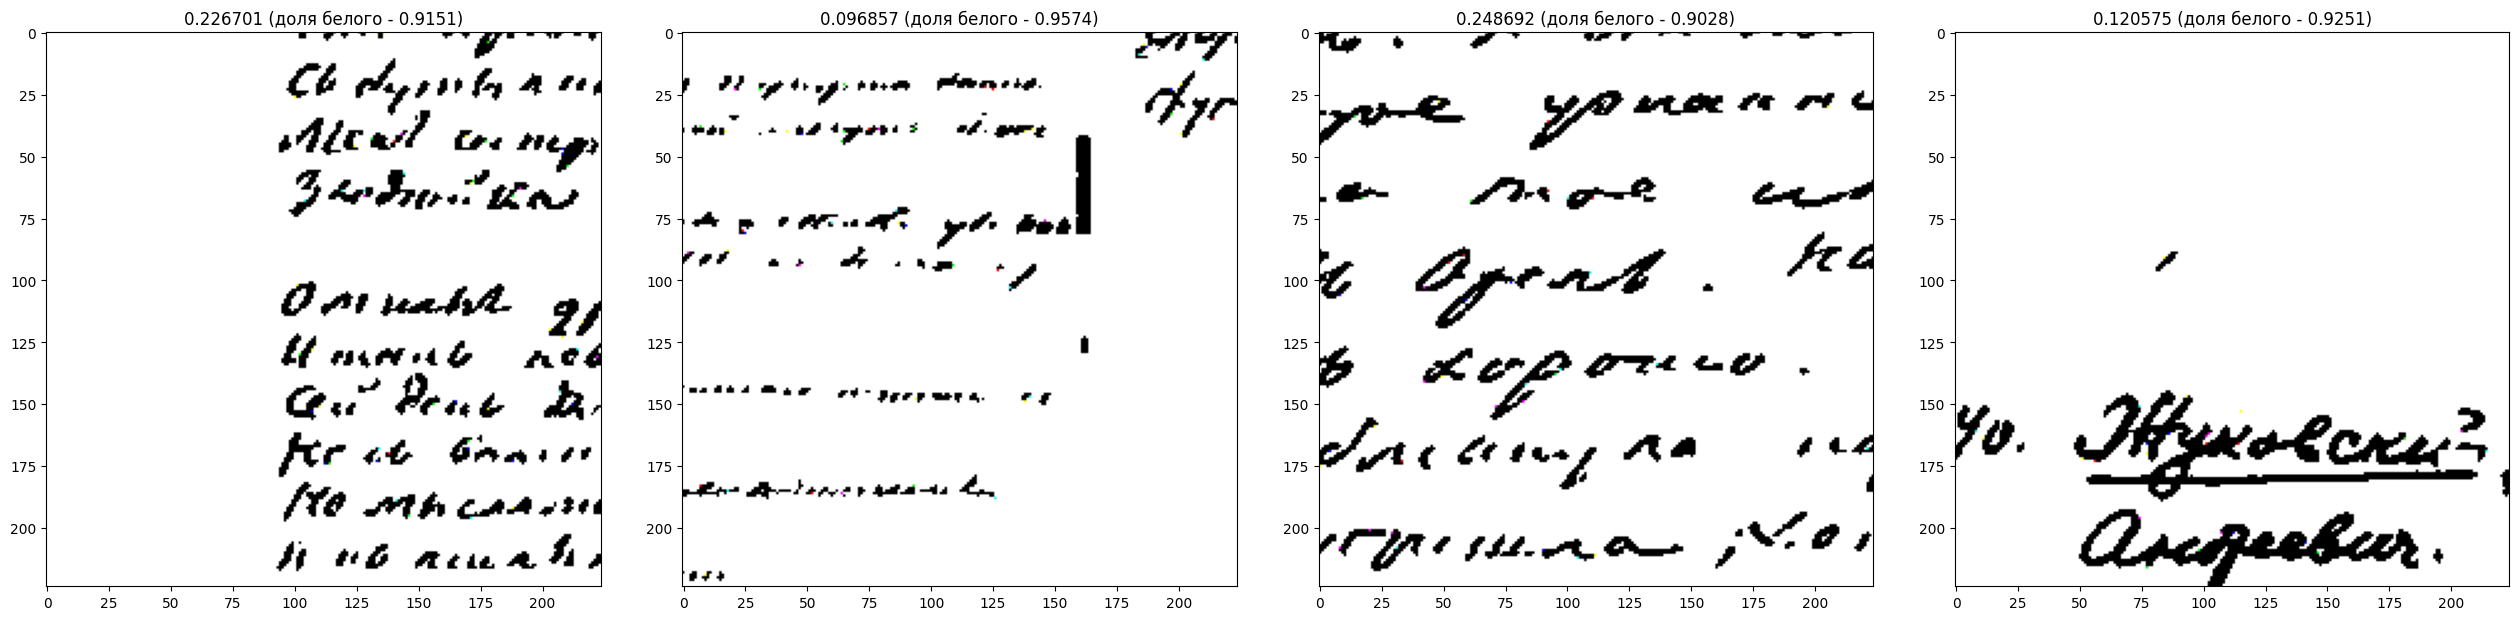

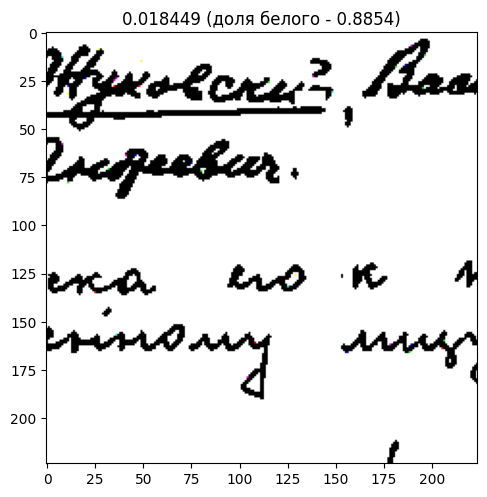

In [144]:
y_pred, _, y_prob, X = show_result(pipe, pos_dataset, 0.6, greater = False, col = 8,
                                   globals=glob_dict)

In [145]:
y_pred, _, y_prob, X = show_result(pipe, neg_dataset, 0.3, greater = False, col = 24,
                                   seed = 41, globals=glob_dict)

Output hidden; open in https://colab.research.google.com to view.

prob > 0.6
count : 11 out of 448
pic idx : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


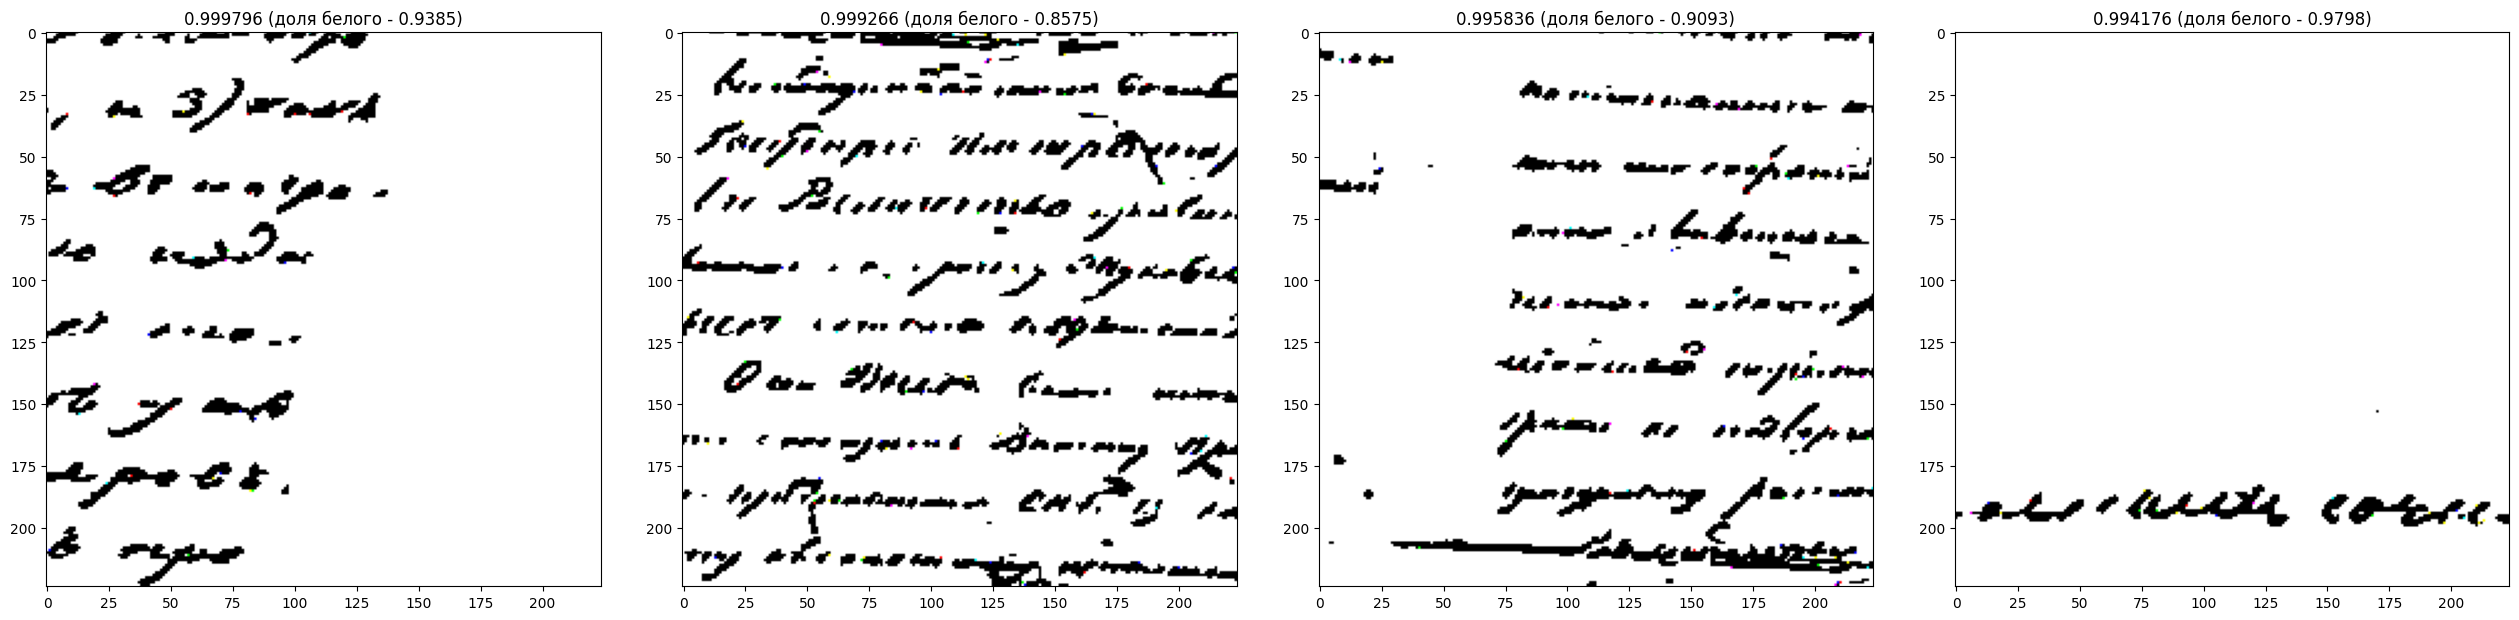

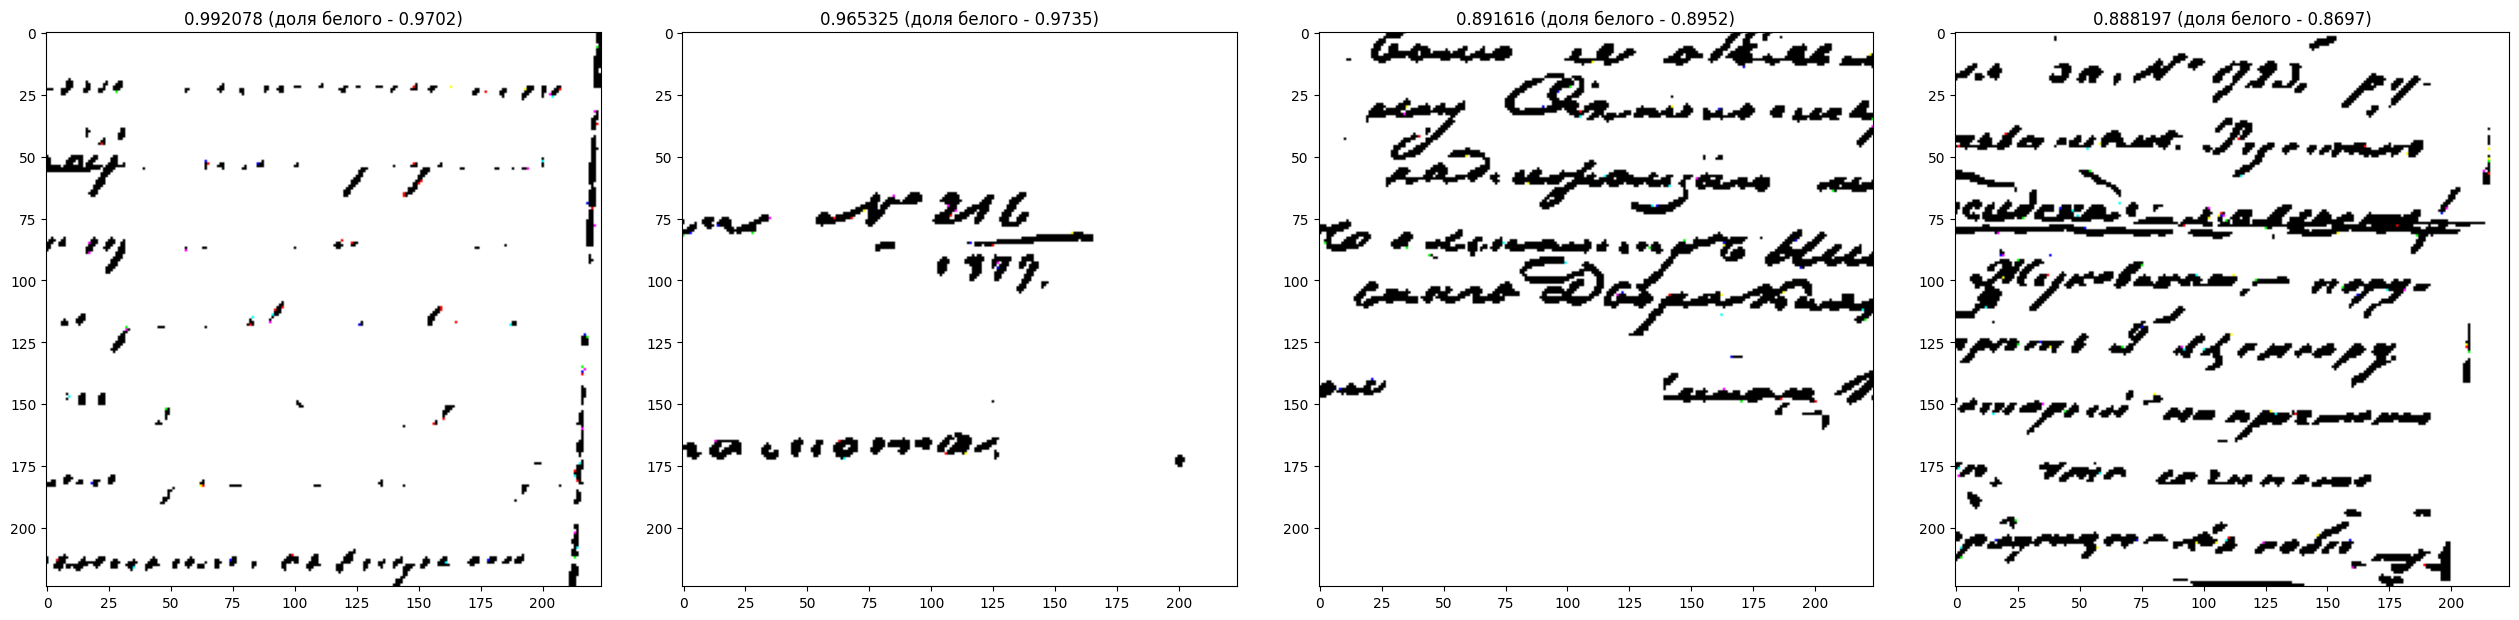

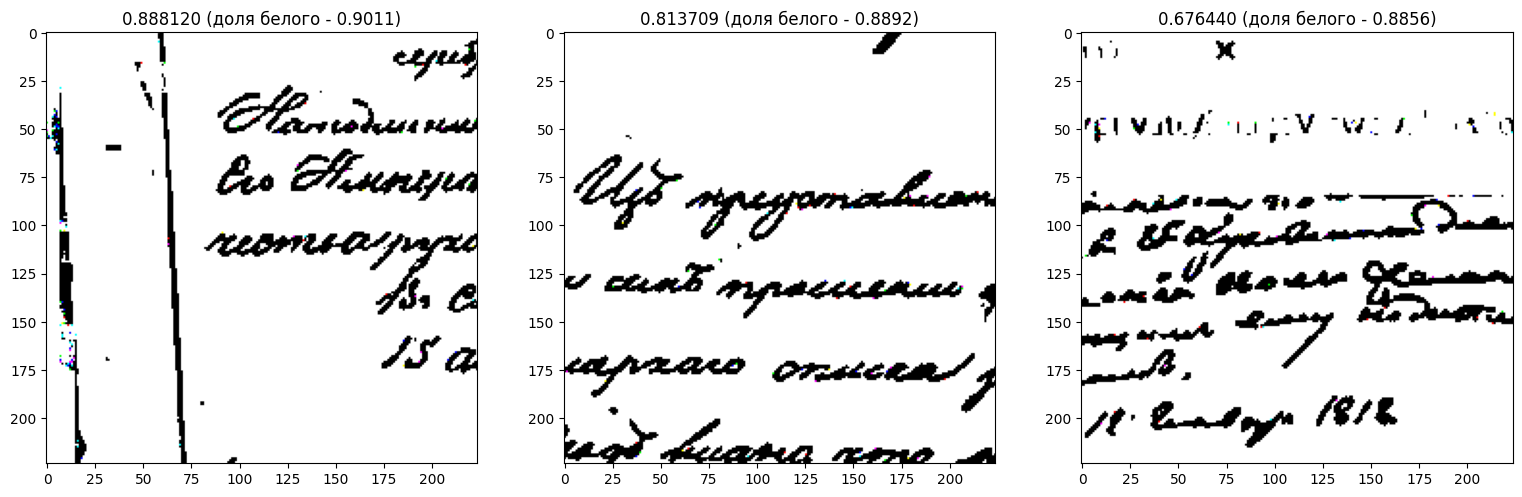

In [150]:
y_pred, _, y_prob, X = show_result(pipe, neg_dataset, 0.6, greater = True, col = 24,
                                   sort = True, globals=glob_dict)

In [ ]:
# img = pos_dataset[0][0]
# img.shape

In [ ]:
# s = set()
# for i in range(300):
#     for j in range(300):
#         s |= {tuple(img[:, i, j].tolist())}

# s

In [ ]:
# x, num = np.unique(img.max(dim = 0)[0], return_counts = True)
# x, num

In [ ]:
# plt.figure(figsize=(20, 20))

# plt.imshow(np.transpose(img, (1, 2, 0)))

# on the entire dataset

In [148]:
y_pred, _, y_prob, X = show_result(pipe, neg_dataset, 0, greater = True, col = 224,
                                   sort = True, globals=glob_dict)

Output hidden; open in https://colab.research.google.com to view.

In [149]:
y_pred, _, y_prob, X = show_result(pipe, pos_dataset, 0, greater = True, col = 224,
                                   sort = True, globals=glob_dict)

Output hidden; open in https://colab.research.google.com to view.